# Экспорт некоторых значений из zabbix api

По традиции,  в zabbix нет никакого способа выгрузить значения. Этот функционал отдан на откуп API.
В этом блокноте реализован пример выгрузки данных в более удобные аналитические форматы.

С некоторых пор функционал выгрузки в CSV появился в Grafana, которая часто используется вместе с Zabbix.

In [1]:
import matplotlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import requests
import json
import time
from datetime import datetime
import pandas as pd

In [2]:
ZABBIX_URI = 'https://domain.url/zabbix/api_jsonrpc.php'
ZABBIX_USR = ''
ZABBIX_PWD = ''

In [3]:
# специальный модуль loca_secrets.py  содержащий значения переменных.
# нужно самостоятельно создать файл используя шаблон выше.
# Этот модуль нужен чтобы пароли не гуляли по jupyter notebook.
# Ноутбуком можно спокойно поделиться.
from  local_secrets import *

### Настройки скрипта ###
hostid и itemid  легко найти на странице Latest data. При просмотре графиков их можно достать из URL браузера.

In [4]:
hostid = 10360
itemid = 36546
# начало выгрузки
starttime = '2022-05-01 0:0:00'
# Имя  временной зоны для коррекции. 
dst_correction_zone = 'Europe/Moscow'

Несколько служебных функций.

Для zabbix существует масса специальных модулей, но данное решение ситуационное и их существование игнорирует.

In [5]:
def zabbixLogin(user, passwd):
  params = {
    'user':user,
    'password':passwd
  }
  return zabbixCall('user.login', params)

In [6]:
def zabbixCall(method='', params={}, auth=''):
    data = {
        'jsonrpc':'2.0',
        'method':method,
        'params':params,
        'id':1
      }
    if len(auth) != 0:
        data['auth'] = auth
    r = requests.post(ZABBIX_URI, data=json.dumps(data), headers={'content-type':'application/json-rpc'})
    #print("\n\n code ",r.status_code)
    #print('json ret',r.json())
    return r.json()['result']

In [7]:
authId = zabbixLogin(ZABBIX_USR, ZABBIX_PWD)
#print('Проверка авторизации: ' + authId)
params = {
  'hostids':hostid,
  'itemids':itemid
}
items = zabbixCall('item.get', params, authId)

print('Элемент данных',items[0]['name'])

Элемент данных /dev/nvme1: ID 190/194 Temperature


Старые данные в zabbix агрегируются по часам и хранятся в виде так называемых trends. Актуальные данные хранятся с произвольной точностью.
Здесь мы получим и объединим оба набора данных.

In [8]:
begin = int((pd.to_datetime([starttime]).astype(int) / 10**9) [0])

params = {
    'output':'extend',
    #'history':1,
    'itemids':itemid,
    'time_from':begin
    }
ret = zabbixCall('trend.get', params, authId)
trend=pd.DataFrame(ret)
trend.head(5)

,itemid,clock,num,value_min,value_avg,value_max
0,36546,1651363200,12,45,45,46
1,36546,1651366800,12,44,44,45
2,36546,1651370400,12,45,45,45
3,36546,1651374000,12,44,44,45
4,36546,1651377600,12,45,46,48


In [9]:
trend=trend[['itemid','clock','value_avg']].rename(columns={"value_avg": "value"})
trend

,itemid,clock,value
0,36546,1651363200,45
1,36546,1651366800,44
2,36546,1651370400,45
3,36546,1651374000,44
4,36546,1651377600,46
...,...,...,...
1114,36546,1655373600,54
1115,36546,1655377200,54
1116,36546,1655380800,54
1117,36546,1655384400,54


Трансляция и перевод данных в оптимальные типы pandas

In [11]:
trend.value=trend.value.astype('int64')
trend.itemid=trend.itemid.astype('int64')
trend.clock=trend.clock.astype('int64')
trend['ns']=0
trend

,itemid,clock,value,ns
0,36546,1651363200,45,0
1,36546,1651366800,44,0
2,36546,1651370400,45,0
3,36546,1651374000,44,0
4,36546,1651377600,46,0
...,...,...,...,...
1114,36546,1655373600,54,0
1115,36546,1655377200,54,0
1116,36546,1655380800,54,0
1117,36546,1655384400,54,0


In [12]:
# или будем эскпортировать самые свежие данные?
#begin = int(time.mktime(datetime.now().timetuple()) - 3600 * HOURS)
print(begin)

begin = int((pd.to_datetime([starttime]).astype(int) / 10**9) [0])

params = {
    'output':'extend',
    #'history':1,
    'itemids':itemid,
    'time_from':begin
    }
ret = zabbixCall('history.get', params, authId)
df=pd.DataFrame(ret)
df.head(5)

1651363200


,itemid,clock,value,ns
0,36546,1654788844,56,946849665
1,36546,1654789144,56,907556172
2,36546,1654789444,56,122993304
3,36546,1654789744,56,98182063
4,36546,1654790044,56,146744874


In [13]:
df.value=df.value.astype('int64')
df.itemid=df.itemid.astype('int64')
df.clock=df.clock.astype('int64')
df.ns=df.ns.astype('int64')

In [14]:
#Объединяем trend и df
df = pd.concat([trend,df])

In [15]:
df=df.sort_values('clock')
df['ts']=pd.to_datetime(df['clock'],unit='s',origin='unix')

df['ts'] = df['ts'].dt.tz_localize('UTC').dt.tz_convert(dst_correction_zone)

In [16]:
df=df[['ts','value']]

### Визуальный контроль данных в виде графика. ###
Можно использовать для ситуационного "прицеливания" диапазонов выгрузки

<AxesSubplot:xlabel='ts'>

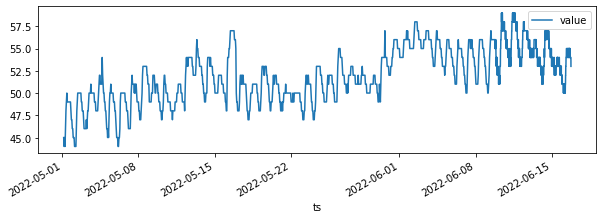

In [21]:
df.plot(x='ts',y='value',figsize=(10,3))

Более точные границы выгрузки интересующего промежутка

In [22]:
cut_from='2022-05-01 0:0:0'
cut_to='2022-06-20 0:0:0'

In [23]:
df=df[(cut_from < df['ts']) &  (df['ts']< cut_to)]

In [24]:
df

,ts,value
0,2022-05-01 03:00:00+03:00,45
1,2022-05-01 04:00:00+03:00,44
2,2022-05-01 05:00:00+03:00,45
3,2022-05-01 06:00:00+03:00,44
4,2022-05-01 07:00:00+03:00,46
...,...,...
2013,2022-06-16 18:19:04+03:00,54
2014,2022-06-16 18:24:04+03:00,54
2015,2022-06-16 18:29:04+03:00,54
2016,2022-06-16 18:34:04+03:00,54


<AxesSubplot:xlabel='ts'>

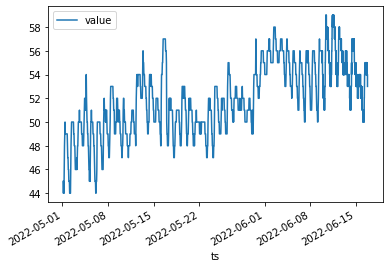

In [25]:
df.plot(x='ts',y='value')

### Сохранение на диск в  удобном формате ###
Можно использовать все принятые в pandas способы.
В данной ситуации, для сокращения объема данных, удаляем timezone.

In [28]:
df['ts']=df['ts'].dt.tz_localize(None)
df.to_csv('exported-from-zabbix-monotonic.csv')

## См. так же: ##

Эти явно сезонные данные можно прогнозировать с помощью  [Facebook Prophet](prophet.ipynb)